Анализ ПИФа "Сбербанк Америка" и его сравнение c benchmark portfolio 

In [164]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.data as web
from dbfpy import dbf
import xlrd

In [163]:
%matplotlib inline
plt.style.use('bmh') # The most fanciest styles are 'ggplot' and 'fivethirtyeight'
# All available styles may be checked by
#print plt.style.available

In [71]:
csvfilename = 'Sberbank  America.csv'
usdratefilename = 'R01235.dbf'

In [131]:
def get_rate(date):
    try:
        return usdrates[date]
    except KeyError:
        return get_rate(date-datetime.timedelta(1))

Парсинг исторических значений курса доллара к рублю

In [184]:
usdrates = {}
db = dbf.Dbf(usdratefilename)
for rec in db:
    date = rec[0]
    rate = float(rec[2])
    usdrates[date]=rate

Парсинг исторических данных ПИФа Райффайзена:

In [165]:
raiffdatafilename = "01.01.2007-03.03.2016.xls"

In [188]:
raiff_dates = []
raiff_prices = []
rb = xlrd.open_workbook(raiffdatafilename,formatting_info=True)
sheet = rb.sheet_by_index(0)
for rownum in range(sheet.nrows):
    try:
        row = sheet.row_values(rownum)
        date = datetime.datetime.strptime(row[0], "%d.%m.%Y").date()
        price = float(row[2])
        usdprice = price / get_rate(date)
        raiff_dates.append(date)
        raiff_prices.append(usdprice)
    except UnicodeEncodeError: # skip headers
        continue
    except RuntimeError:
        print date
    

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
2007-01-09
2006-12-29


Парсинг исторических данных ПИФа Сбербанка:

Данные фонда в формате csv могут быть взяты из 
http://www.sberbank-am.ru/rus/Individuals/Mutual_Funds/Federal/index.wbp

In [194]:
sber_dates = []
sber_prices = []
with open(csvfilename, 'rb') as csvfile:
    datareader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row, r in zip(datareader, usdrates) :
        date = datetime.datetime.strptime(row[0], "%d-%m-%y").date()
        price = float(row[1].replace(',','.'))
        usdprice = price / get_rate(date)
        #print row[0]
        sber_dates.append(date)
        sber_prices.append(usdprice)
        #print ', '.join(row)
end_date = sber_dates[0]
start_date = sber_dates[-1]

In [195]:
spy = pd.DataFrame()
spy = web.DataReader('SPY', data_source='yahoo', start=start_date, end=end_date)['Adj Close']  

In [219]:
print 'Raiff price at ' + str(raiff_dates[-1]) + ': ' + str(raiff_prices[-1]) + ' USD'
print 'Sber price at ' + str(sber_dates[-1]) + ': ' + str(sber_prices[-1]) + ' USD'
print 'SPDR ETF price at ' + str(start_date) + ': ' + str(spy[0]) + ' USD'

Raiff price at 2007-01-10: 384.915584293 USD
Sber price at 2007-01-10: 37.8080275273 USD
SPDR ETF price at 2007-01-10: 117.415864 USD


Т.к. цена за пай сбера и райффа отличаются, нормализуем их друг относительно друга:

In [207]:
sber_raiff_rate = raiff_prices[-1]/sber_prices[-1]
print sber_raiff_rate

10.1807898869


sber_raiff_rate показывает, за сколько паев Сбера можно купить 1 пай Райффа

In [208]:
sber_prices_adj = [] 
for p in sber_prices: 
    sber_prices_adj.append(p * sber_raiff_rate)

Нормализуем долларовые цены SPDR SP500 ETF относительно райффа

In [213]:
spdr_raiff_rate = raiff_prices[-1]/spy[0]
print spdr_raiff_rate

3.27822468941


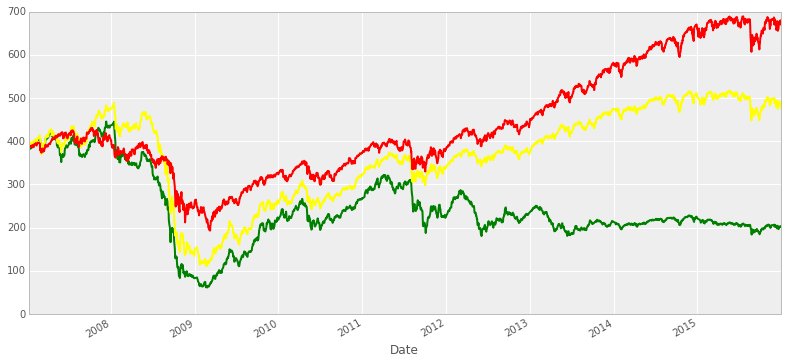

In [220]:
plt.figure(figsize=(12, 6))
plt.plot(sber_dates, sber_prices_adj, color='green')
plt.plot(raiff_dates, raiff_prices, color='yellow')
(spy * spdr_raiff_rate).plot(color='red')

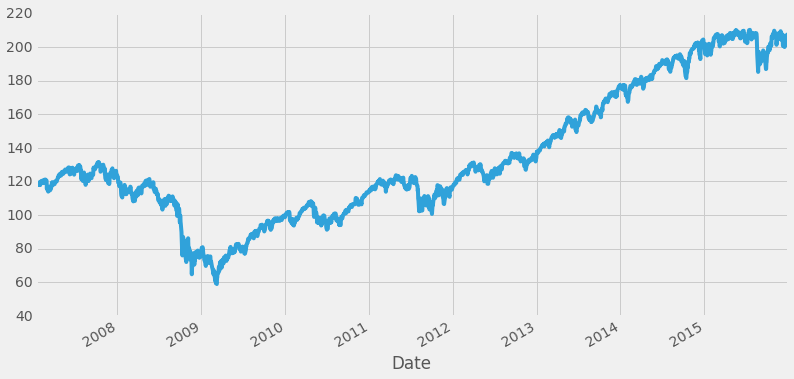

In [64]:
plt.figure(figsize=(12, 6))
spy.plot()